# SIS model on random regular graph
Comparison with Soft Margin montecarlo

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Printf, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

In [152]:
T = 60
N = 25
k = 4
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.15
ρ = 0.12
λ = 0.05
ρ = 0.04
γ = 3/N

sis = SIS(g, λ, ρ, T; γ);

In [153]:
bp = mpbp(sis)
cb = CB_BP(bp)

nobs = N÷2
x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2);

In [126]:
svd_trunc = TruncBond(4)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-4)
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Running MPBP: iter 14 	 Time: 0:10:17
  Δ:  6.418290605399168e-5

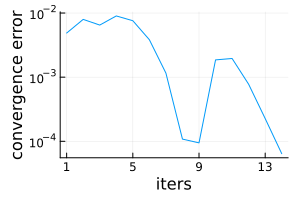

In [140]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [128]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [129]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
ns = 10^6
sample!(sms, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:03:36:47


In [130]:
ns = 10^6
sms = sample(bp, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:03:1839m


SIS on random regular graph N=25, k=4. P(S→I)=0.15, P(I→S)=0.12. P(zero patient)=0.12
12 random node observations at final time.
Max matrix size: 4x4


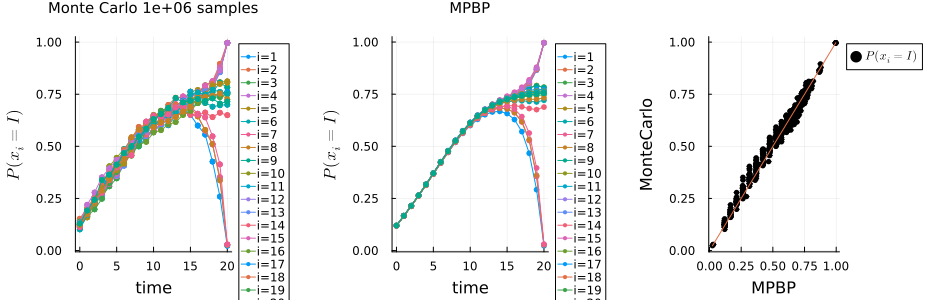

In [131]:
title = @sprintf "Monte Carlo %.0e samples" ns
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$ρ. P(zero patient)=", round(γ, digits=3))
println("$nobs random node observations at final time.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [132]:
c_bp = autocovariances(bp);

In [133]:
using ColorSchemes
function plot_autocovs!(pl, c; us = 5:5:size(c,1)-1,
        cg = cgrad(:matter, length(us), categorical=true), kw...)
    ylabel = "\$\\langle x_i^t x_i^{t+\\Delta t}\\rangle-" * 
        "\\langle x_i^t\\rangle\\langle x_i^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    plot!(pl ;xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-1:1, c[(0:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  
plot_autocovs(args...; kwargs...) = plot_autocovs!(plot(), args...; kwargs...)

plot_autocovs (generic function with 1 method)

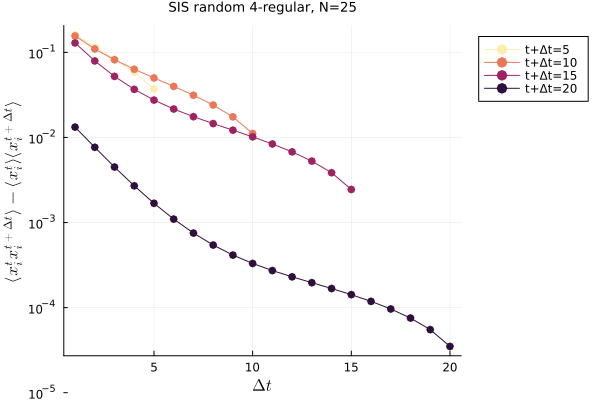

In [134]:
i = 1
plot_autocovs(c_bp[i], title="SIS random $k-regular, N=$N", yaxis=:log10, yticks=6, titlefontsize=9)

## Varying the size of matrices

In [154]:
sizes = [4, 6]
magnetizations = [[zeros(0) for _ in 1:N] for _ in sizes]
covariances = [[zeros(0, 0) for _ in 1:N] for _ in sizes];

In [155]:
for s in eachindex(sizes)
    println("### Size $s of $(length(sizes))")
    cg = cgrad(:matter, length(sizes), categorical=true)
    sz = sizes[s]
    svd_trunc = TruncBond(sz)
    reset_messages!(bp)
    iters, cb = iterate!(bp, maxiter=200; svd_trunc, tol=1e-4)
    b_bp = beliefs(bp)
    magnetizations[s] = [[bbb[2] for bbb in bb] for bb in b_bp]
    covariances[s] = autocovariances(bp)
end

Running MPBP: iter 11 	 Time: 0:03:29
  Δ:  6.56903589176909e-5

In [156]:
i = 5

pl_mag = plot(); pl_cov = plot()
cg = cgrad(:matter, length(sizes), categorical=true)

for s in eachindex(sizes)
    sz = sizes[s]
    plot!(pl_mag, 0:T, magnetizations[s][i], m=:o, xlabel="time", ylabel="\$P(x_i=I)\$",
        size=(600,300), xticks=0:10:T, ms=2, c = cg[s], msc=cg[s],
        label = "Matrix size $sz", legend=:topleft)
    us = 5:5:size(covariances[s][i],1)-1
    plot_autocovs!(pl_cov, covariances[s][i]; us, cg = cgrad(fill(cg[s], length(us))), yaxis=:log10,
        yticks = 4)
    plot!(pl_cov, title="")
end

In [158]:
plot(pl_mag, pl_cov, size=(900,300), margin=5Plots.mm)

┌ Warning: Invalid negative or zero value -3.308722450212111e-24 found at series index 4 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/jqILG/src/utils.jl:85
┌ Warning: Invalid negative or zero value -1.737079286361358e-23 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/jqILG/src/utils.jl:85
